In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn import datasets
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    
    for tree_idx, tree in enumerate(model):
        
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        for vote_index in vote_indices:
            class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
        for elem in where_empty:
            class_probs[elem] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy = np.mean(eval_entropies)
        
        return cond_entropy

In [5]:
def generate_datasets(n_samples, datasets): 
    # Taken from : https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                          noise=.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    # Default parameters.
    default_base = {'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1}

    data = [
        (noisy_circles, {'damping': .77, 'preference': -240,
                         'quantile': .2, 'n_clusters': 2,
                         'min_samples': 20, 'xi': 0.25}),
        (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
        (varied, {'eps': .18, 'n_neighbors': 2,
                  'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
        (aniso, {'eps': .15, 'n_neighbors': 2,
                 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
        (blobs, {}),
    ]
    
    return data

In [6]:
def plot_settings(axes, colors, names, data):
    for i_dataset, (dataset, algo_params) in enumerate(data):
        X, y = dataset
        
        # Assumes y is in {0, ..., K}
        axes[i_dataset].scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
        axes[i_dataset].set_xticks(())
        axes[i_dataset].set_yticks(())

        axes[i_dataset].set_ylabel(names[i_dataset])

In [7]:
def estimate_mi(X, y, label):
    
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return est_H_Y - np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return est_H_Y - uf(np.array(X), y)
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1)) 
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Unrecognized Label!")

In [8]:
def get_mutual_info_vs_n(sample_sizes, num_trials, algos):    
    # This worker is just for one algorithm.
    def worker(t):
        out = []
        data = generate_datasets(elem, datasets)
        num_settings = len(data)
        for i_dataset, (dataset, algo_params) in enumerate(data):
            X, y = dataset
            out.append(estimate_mi(X, y, label))
        return tuple(out)

    settings = ['annulus', 'cresent', 'class_dep_cov', 'ellyptical', 'scattered']
    results = np.zeros((len(algos), len(sample_sizes), len(settings)))
    for i, elem in enumerate(sample_sizes):
        for j, algo in enumerate(algos):
            label = algo['label']
            # num_trials by num_settings
            output = np.mean(np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials))), axis = 0)
            for s in range(len(settings)):
                results[j, i, s] = output[s]
    
    for s, setting in enumerate(settings):
        for j, algo in enumerate(algos):
            filename = '%s_by_n_%s.pkl' % (algo['label'], setting)
            to_dump = results[j, :, s]
            pickle.dump(to_dump, open(filename, 'wb'))
    pickle.dump(sample_sizes, open('sample_sizes.pkl', 'wb'))

In [9]:
# Real Params.
sample_sizes = range(100, 2501, 300)
num_trials = 20

# Real Params.
# sample_sizes = range(150, 180, 10)
# num_trials = 3

# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [10]:
# mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = parallel)
get_mutual_info_vs_n(sample_sizes, num_trials, algos)

In [11]:
def plot_mutual_info_by_n(setting, algos, ax):
    sample_sizes = pickle.load(open('sample_sizes.pkl', 'rb'))
    for algo in algos:
        filename = '%s_by_n_%s.pkl' % (algo['label'], setting)
        algo_results = pickle.load(open(filename, 'rb'))
        ax.plot(sample_sizes, 
                algo_results, 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])
        ax.set_ylim(bottom = -0.05)
        ax.set_ylim(top = 1.65)
        ax.set_ylabel("Estimated Mutual Info")

In [12]:
def plot_fig5():
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    num_settings = 5
    
    fig, axes = plt.subplots(num_settings, 2, figsize = (14,25))
    
    colors = ["#2166ac", "#c51b7d", "#d95f02"]
    names = ['Annulus', 'Cresent Moons', 'Class-Dependent Covariance', 'Ellyptical Gaussians', 'Scattered Means']
    settings = ['annulus', 'cresent', 'class_dep_cov', 'ellyptical', 'scattered']
    
    plot_settings(axes[:,0], colors, names, generate_datasets(1000, datasets))
    for s, setting in enumerate(settings):
        plot_mutual_info_by_n(setting, algos, axes[s,1])
    
    axes[num_settings-1, 1].legend(loc = "lower right")
    axes[0, 0].set_title("Setting")
    axes[0, 1].set_title("Mutual Information versus Sample Size")
    
    plt.savefig("fig5.pdf")
    plt.show()

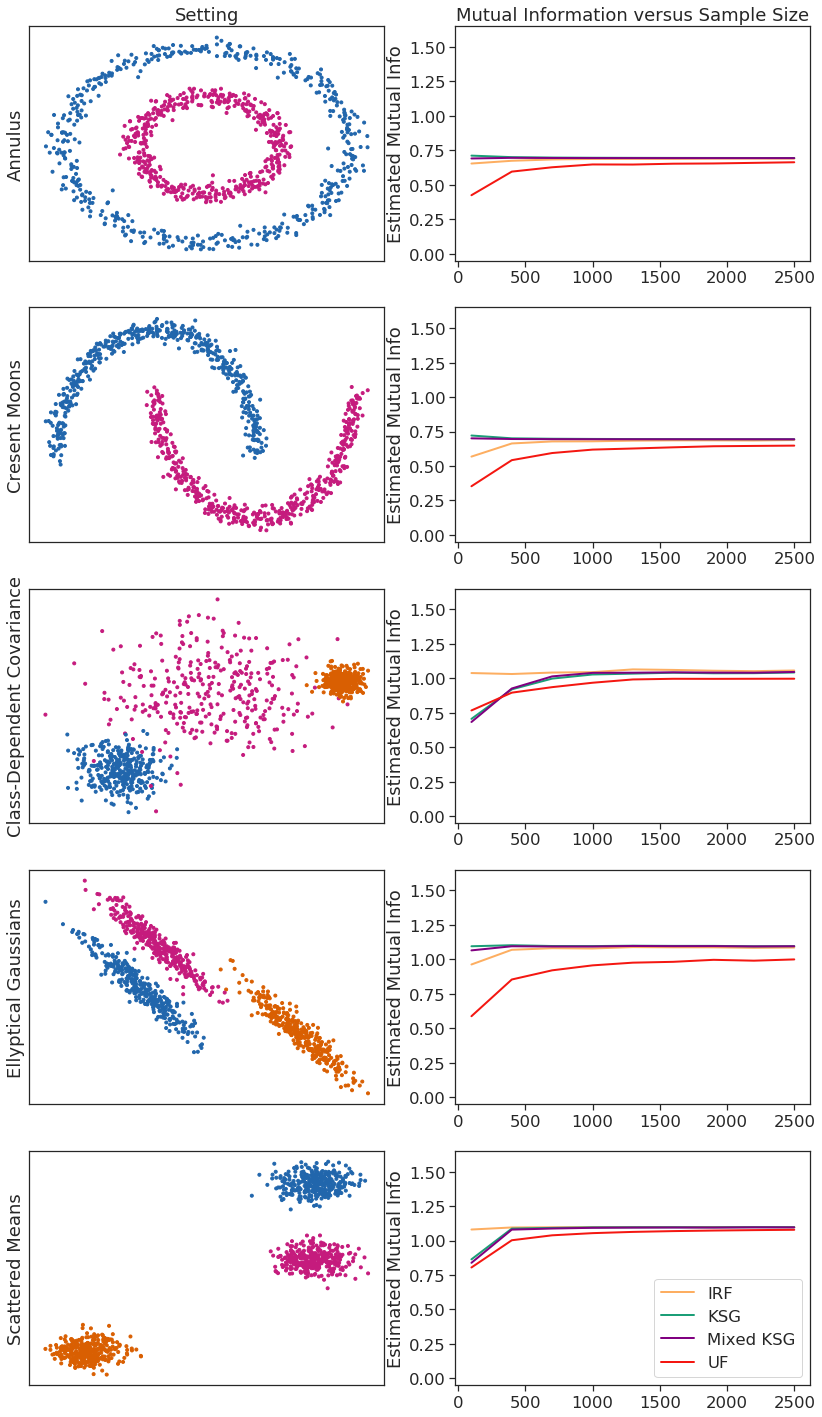

<Figure size 1512x900 with 0 Axes>

In [13]:
plot_fig5()